In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
import librosa
import soundfile as sf
import numpy as np
import os
import glob
import json

import torch
from text.lang_type import l2num as lt
from text import IPA_id
from text.multi_apha import letter_
import commons
import attentions
import utils
import models_lstm as models
from utils import load_wav_to_torch, load_filepaths_and_text, load_flac_to_torch

model_path = '/media/caijb/data_drive/glowtts_zeroshot/logs/zero_multi_LSTM'

In [2]:
class inf_data():
    def __init__(self,hparams):
        self.feature_vector = hparams.feature_files
        with open(self.feature_vector,'r',encoding='UTF-8') as f:
            d_w  = f.read().split('\n')
        self.feature_dict = dict()
        for i in d_w:
            a_sid = i.split('|')
            if len(a_sid)>=2:
                self.feature_dict[a_sid[1]] = a_sid[0]
        #print(self.feature_dict)
        
        self.stft = commons.TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)
        self.n_mels = hparams.n_mel_channels
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
        self.add_noise = hparams.add_noise
        self.add_blank = getattr(hparams, "add_blank", False) # improved version
        self.min_text_len = getattr(hparams, "min_text_len", 1)
        self.max_text_len = getattr(hparams, "max_text_len", 190)
        self.slice_length = hparams.slice_length
        
    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            if filename[-4:]=='flac':
                audio,sampling_rate=load_flac_to_torch(filename)
            else:
                audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(sampling_rate, self.stft.sampling_rate))
            if self.add_noise:
                audio = audio + torch.rand_like(audio)
            audio_norm = audio / self.max_wav_value
            audio_norm = audio_norm.unsqueeze(0)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))

        return torch.abs(melspec)/torch.max(torch.abs(melspec))
    
    def get_text(self, text, lang):
        text_norm = IPA_id.text_to_sequence(text,lang)
        if self.add_blank:
            with open ('./text/IPA.txt','r',encoding='UTF-8') as f:
                ipa = f.read()
                ipa = list(ipa)
            text_norm = commons.intersperse(text_norm, len(ipa)) # add a blank token, whose id number is len(symbols)
        text_norm = torch.IntTensor(text_norm)
        return text_norm
    
    def get_sid(self, sid):
        a_path = self.feature_dict[sid]
        feature_mel = self.get_mel(a_path)
        mel_emb = torch.FloatTensor(1,self.n_mels, self.slice_length)
        mel_emb.zero_()
        if feature_mel.size(1) > self.slice_length +100:
            mel_emb[0, :, :self.slice_length] = feature_mel[:, 100:self.slice_length+100]
        elif mel_norm.size(1) > self.slice_length :
            mel_emb[0, :, :self.slice_length] = feature_mel[:, :self.slice_length]
        else :
            mel_emb[0, :, :mel_norm.size(1)] = feature_mel
        sid = torch.IntTensor([int(sid)])
        return sid , mel_emb
    
    def get_lang(self, lang):
        lang,e_lang=lt(lang)
        lang=torch.IntTensor([int(lang)])
        return lang,e_lang

        
    def get_data(self, text, sid, lang):
        sid, mel_emb = self.get_sid(sid)
        lang, lang_e = self.get_lang(lang)
        text_norm = self.get_text(text, lang_e)
        
        return text_norm, mel_emb, lang, sid, lang_e

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [4]:
hps = utils.get_hparams_from_dir(model_path)
print(hps)
checkpoint_path = utils.latest_checkpoint_path(model_path)

generator = models.FlowGenerator(
      n_vocab=len(letter_) + getattr(hps.data, "add_blank", False), 
      out_channels=hps.data.n_mel_channels,n_speakers=hps.model.n_speaker,
      gin_channels=512,LSTM_hidden = hps.LSTM.l_hidden ,n_lang= 2 ,**hps.model).cuda()

generator,_,_,_ = utils.load_checkpoint(checkpoint_path, generator)

{'train': {'use_cuda': True, 'log_interval': 100, 'seed': 1234, 'epochs': 1000, 'learning_rate': 1.0, 'betas': [0.9, 0.98], 'eps': 1e-09, 'warmup_steps': 4000, 'scheduler': 'noam', 'batch_size': 32, 'ddi': False, 'fp16_run': False}, 'data': {'load_mel_from_disk': False, 'training_files': '/media/caijb/data_drive/data/Zeroshot/vctk_train_8.txt', 'validation_files': '/media/caijb/data_drive/data/Zeroshot/vctk_test_8.txt', 'feature_files': '/media/caijb/data_drive/data/Zeroshot/vctk_feature.txt', 'text_cleaners': ['korean_cleaners'], 'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': 8000.0, 'add_noise': False, 'add_blank': True, 'slice_length': 430}, 'model': {'hidden_channels': 192, 'filter_channels': 768, 'filter_channels_dp': 256, 'kernel_size': 3, 'p_dropout': 0.1, 'n_blocks_dec': 12, 'n_layers_enc': 6, 'n_heads': 2, 'p_dropout_dec': 0.05, 'dilation_rate': 1, 'kernel_size_d

/home/caijb/Desktop/zero_shot_glowtts/modules.py:205: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2491.)
  w_init = torch.qr(torch.FloatTensor(self.n_split, self.n_split).normal_())[0]


INFO:root:Loaded checkpoint '/media/caijb/data_drive/glowtts_zeroshot/logs/zero_multi_LSTM/G_883.pth' (iteration 883)


/home/caijb/Desktop/zero_shot_glowtts/stft.py:68: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/home/caijb/Desktop/zero_shot_glowtts/commons.py:172: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * 

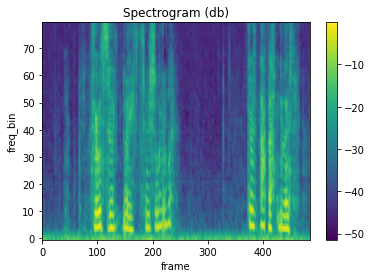

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


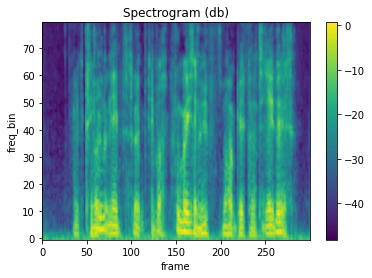

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


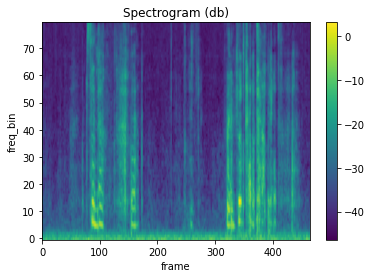

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


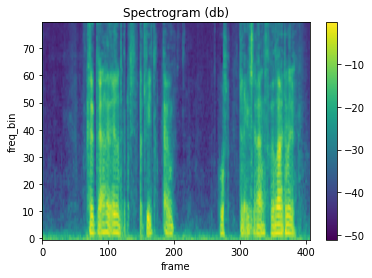

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


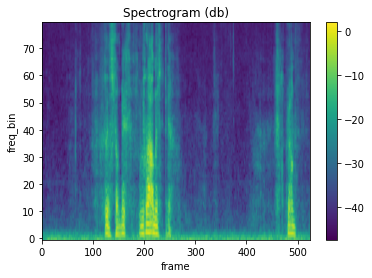

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


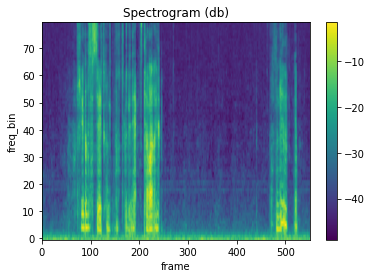

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


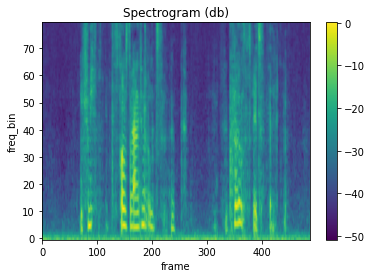

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


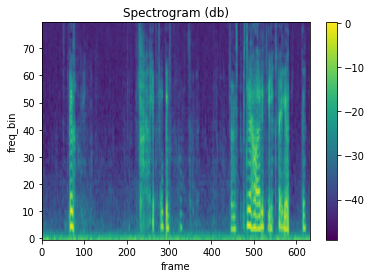

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


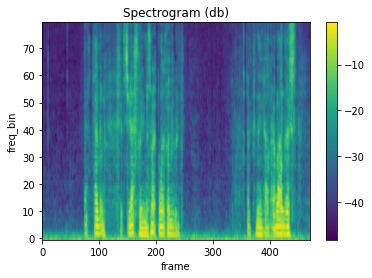

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


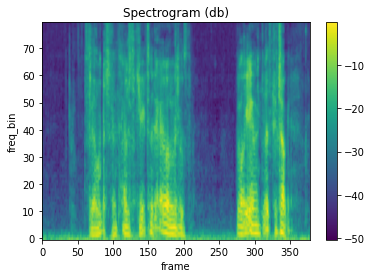

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


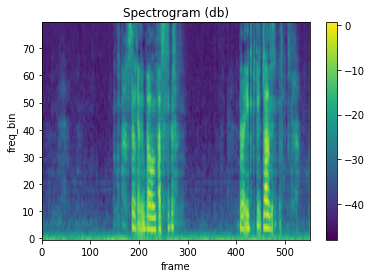

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


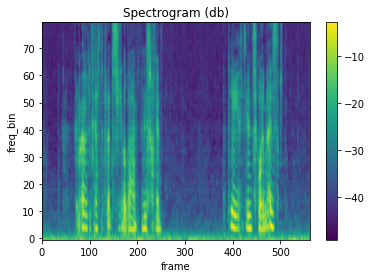

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


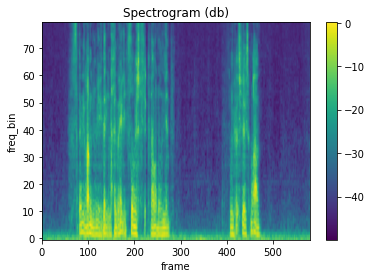

/home/caijb/Desktop/zero_shot_glowtts/models_lstm.py:342: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


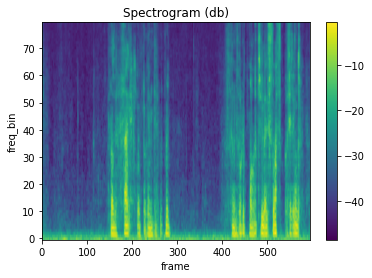

In [5]:
load_data = inf_data(hps.data)
#dutch 0, english 1, franch 2, spanish 3
#sid 0~109, 113~125
#f 2,16,68,77
#m 9,33,62,66
#uf 6, 19
#um 34, 81
text="Some have accepted it as a miracle without physical explanation."
#sid = '114'
seen_sid = ['2','9','16','33','62','66','68','77']
unseen_sid = ['6','19','34','81']
cross_sid = ['1','114']
lang_ = 'english'
save_path = './hifi-gan/test_mel_files/LSTM_monolingual/'

if not os.path.exists('./hifi-gan/test_mel_files/LSTM_monolingual/'):
        os.makedirs('./hifi-gan/test_mel_files/LSTM_monolingual/')

with torch.no_grad():
    for sid in seen_sid:
        save_name = 'seen_'+sid
        text_ipa, mel_emb, lang, sid, lang_e = load_data.get_data(text,sid,lang_)
        text_lengths = torch.tensor(text_ipa.size()).cuda()
        text_ipa = text_ipa.unsqueeze(dim=0).cuda()
        mel_emb = mel_emb.cuda()
        lang = lang.cuda()
        (y_gen, *_), *_, (attn_gen, *_) = generator(text_ipa, text_lengths,g=mel_emb,l=lang, gen=True)
        np.save(save_path+save_name+'.npy', y_gen.cpu().detach().numpy())
        import audio_processing as ap
        y_gen=ap.dynamic_range_decompression(y_gen)
        mel=y_gen.detach().cpu()
        mel=mel.numpy()
        plot_spectrogram(mel[0])
        mel_basis=librosa.filters.mel(sr=hps.data.sampling_rate, n_fft=hps.data.filter_length, n_mels=hps.data.n_mel_channels)
        covered_mel=librosa.util.nnls(mel_basis, mel[0])
        audio=librosa.griffinlim(covered_mel,n_iter=60)
        sf.write(save_path+save_name+'_griffin.wav', audio, 22050, subtype = 'PCM_16')
        
    for sid in unseen_sid:
        save_name = 'unseen_'+sid
        text_ipa, mel_emb, lang, sid, lang_e = load_data.get_data(text,sid,lang_)
        text_lengths = torch.tensor(text_ipa.size()).cuda()
        text_ipa = text_ipa.unsqueeze(dim=0).cuda()
        mel_emb = mel_emb.cuda()
        lang = lang.cuda()
        (y_gen, *_), *_, (attn_gen, *_) = generator(text_ipa, text_lengths,g=mel_emb,l=lang, gen=True)
        np.save(save_path+save_name+'.npy', y_gen.cpu().detach().numpy())
        import audio_processing as ap
        y_gen=ap.dynamic_range_decompression(y_gen)
        mel=y_gen.detach().cpu()
        mel=mel.numpy()
        plot_spectrogram(mel[0])
        mel_basis=librosa.filters.mel(sr=hps.data.sampling_rate, n_fft=hps.data.filter_length, n_mels=hps.data.n_mel_channels)
        covered_mel=librosa.util.nnls(mel_basis, mel[0])
        audio=librosa.griffinlim(covered_mel,n_iter=60)
        sf.write(save_path+save_name+'_griffin.wav', audio, 22050, subtype = 'PCM_16')
        
    for sid in cross_sid:
        save_name = 'cross_'+sid
        text_ipa, mel_emb, lang, sid, lang_e = load_data.get_data(text,sid,lang_)
        text_lengths = torch.tensor(text_ipa.size()).cuda()
        text_ipa = text_ipa.unsqueeze(dim=0).cuda()
        mel_emb = mel_emb.cuda()
        lang = lang.cuda()
        (y_gen, *_), *_, (attn_gen, *_) = generator(text_ipa, text_lengths,g=mel_emb,l=lang, gen=True)
        np.save(save_path+save_name+'.npy', y_gen.cpu().detach().numpy())
        import audio_processing as ap
        y_gen=ap.dynamic_range_decompression(y_gen)
        mel=y_gen.detach().cpu()
        mel=mel.numpy()
        plot_spectrogram(mel[0])
        mel_basis=librosa.filters.mel(sr=hps.data.sampling_rate, n_fft=hps.data.filter_length, n_mels=hps.data.n_mel_channels)
        covered_mel=librosa.util.nnls(mel_basis, mel[0])
        audio=librosa.griffinlim(covered_mel,n_iter=60)
        sf.write(save_path+save_name+'_griffin.wav', audio, 22050, subtype = 'PCM_16')
    
    
